In [6]:
import numpy as np
import pandas as pd
import tensorflow as tf
import pickle
import sklearn
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score, mean_squared_error
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

In [7]:
dataset_path = "dataset_amyloid.pickle"
with open(dataset_path, 'rb') as f:
    X_train, y_train, X_test, y_test = pickle.load(f)
X = np.concatenate((X_train, X_test), axis=0)
Y = np.concatenate((y_train, y_test), axis=0)


In [106]:
def find_binary_columns(X_train):
    binary_columns = []
    for col in range(X_train.shape[1]):
        unique_values = np.unique(X_train[:, col])
        if set(unique_values).issubset({0, 1}):
            binary_columns.append(col)
    return binary_columns

binary_columns = find_binary_columns(X)

numerical_columns = []
for i in range(0,10193):
    if i not in binary_columns:
        numerical_columns.append(i)
# print(len(binary_columns))
# print(len(numerical_columns))
# print(binary_columns[-1])
# print(numerical_columns[-1])
# print(X.shape)

X_bi = X[:, binary_columns]
X_nu = X[:, numerical_columns]

print(f'Number of Binary columns = {X_bi.shape}')
print(f'Number of Numerical columns = {X_nu.shape}')
print(f'Maximum value of numerical element = {np.max(X_nu)}')
# print(np.max(X_nu)) # 5347441.0
row_total = X_nu.shape[0]
col_total = X_nu.shape[1]
col_lte100 = 0 # number of column with el <= 100: 4037
col_gt100 = 0 # 100 < el <= 1000: 
col_gt1000 = 0 # 1000 < el <= 10000: 
col_gt10000 = 0 # 10000 < el <= 100,000:
col_gt100000 = 0 # 100,000 < el:

col_g = [] # column index for features with elements > 100,000
for col_num in range(0, col_total):
    current_column = X_nu[:, col_num]
    for each in range(0, row_total):
        el = current_column[each]
        if (el > 100000):
            col_gt100000 += 1
            col_g.append(col_num)
            break
        if (el > 10000):
            col_gt10000 += 1
            break
        if (el > 1000):
            col_gt1000 += 1
            break
        if (el > 100):
            col_gt100 += 1
            break
        if (each == 189):
            col_lte100 += 1
    # print(col_num)        
    
print(f'# of columns with element <= 100: {col_lte100}')    
print(f'# of columns with 100 < element <= 1000: {col_gt100}')    
print(f'# of columns with 1000 < element <= 10000: {col_gt1000}')    
print(f'# of columns with 10000 < element <= 100,000: {col_gt10000}')    
print(f'# of columns with 100000 < element: {col_gt100000}')    
# for i in col_g:
#     print(X_nu[:, i])
print(col_g)

Number of Binary columns = (190, 3887)
Number of Numerical columns = (190, 6306)
Maximum value of numerical element = 5347441.0
# of columns with element <= 100: 4037
# of columns with 100 < element <= 1000: 1706
# of columns with 1000 < element <= 10000: 409
# of columns with 10000 < element <= 100,000: 116
# of columns with 100000 < element: 38
[7, 16, 37, 51, 81, 269, 270, 365, 415, 416, 566, 686, 908, 1004, 1701, 1712, 1717, 1742, 1816, 1898, 2110, 2111, 2112, 2631, 2633, 2634, 2635, 2776, 3089, 3123, 3635, 3642, 3666, 3780, 3836, 5119, 5138, 5466]


In [9]:
# Normalizing Data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_nu)

label_encoder = LabelEncoder()
Y_numerical = label_encoder.fit_transform(Y)

In [10]:
class Array_Encoder(nn.Module):
    def __init__(self, output_size, input_size):
        super(Array_Encoder, self).__init__()

        self.fc = nn.Sequential(
            nn.Linear(input_size, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, output_size),
            nn.BatchNorm1d(output_size),
            nn.LeakyReLU(0.2, inplace=True),
        )

    def forward(self, x):
        return self.fc(x)

class Array_Decoder(nn.Module):
    def __init__(self, embedding_size, output_size):
        super(Array_Decoder, self).__init__()

        self.fc = nn.Sequential(
            nn.Linear(embedding_size, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(True),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(True),
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(True),
            nn.Linear(1024, output_size)
        )

    def forward(self, x):
        return self.fc(x)


class Array_Encoder_b(nn.Module):
    def __init__(self, output_size, input_size):
        super(Array_Encoder, self).__init__()

        self.fc = nn.Sequential(
            nn.Linear(input_size, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Sigmoid(256, output_size),
            nn.BatchNorm1d(output_size),
            nn.LeakyReLU(0.2, inplace=True),
        )

    def forward(self, x):
        return self.fc(x)   
    
class Array_Decoder_b(nn.Module):
    def __init__(self, embedding_size, output_size):
        super(Array_Decoder, self).__init__()

        self.fc = nn.Sequential(
            nn.Linear(embedding_size, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(True),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(True),
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(True),
            nn.Sigmoid(1024, output_size)
        )



In [11]:
# Defining Autoencoder model
class Autoencoder(nn.Module):
    def __init__(self, input_size, encoding_dim):
        super(Autoencoder, self).__init__()

        self.encoder = Array_Encoder(output_size=encoding_dim, input_size=input_size)
        self.decoder = Array_Decoder(embedding_size=encoding_dim, output_size=input_size)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

    def encode(self, x):
        return self.encoder(x)

class Autoencoder_b(nn.Module):
    def __init__(self, input_size, encoding_dim):
        super(Autoencoder, self).__init__()

        self.encoder = Array_Encoder_b(output_size=encoding_dim, input_size=input_size)
        self.decoder = Array_Decoder_b(embedding_size=encoding_dim, output_size=input_size)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
        
    def encode(self, x):
        return self.encoder(x)

In [28]:
# Compiling model for numerical data
torch.manual_seed(42)

X_tensor = torch.FloatTensor(X_scaled)

input_size = X_scaled.shape[1]  # Number of input features
encoding_dim = 32  # Desired number of output dimensions
model = Autoencoder(input_size, encoding_dim)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

# Training the autoencoder
num_epochs = 20
for epoch in range(num_epochs):
   # Forward pass
   outputs = model(X_tensor)
   loss = criterion(outputs, X_tensor)


   # Backward pass and optimization
   optimizer.zero_grad()
   loss.backward()
   optimizer.step()

   # Loss for each epoch
   print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')
# Encoding the data using the trained autoencoder
encoded_data = model.encode(X_tensor).detach().numpy()
outputs_np = outputs.detach().numpy()
# outputs_np = scaler.inverse_transform(outputs_data)

Epoch [1/20], Loss: 1.1665
Epoch [2/20], Loss: 1.2544
Epoch [3/20], Loss: 0.9872
Epoch [4/20], Loss: 0.9191
Epoch [5/20], Loss: 0.8726
Epoch [6/20], Loss: 0.8333
Epoch [7/20], Loss: 0.7877
Epoch [8/20], Loss: 0.7469
Epoch [9/20], Loss: 0.7160
Epoch [10/20], Loss: 0.6929
Epoch [11/20], Loss: 0.6731
Epoch [12/20], Loss: 0.6548
Epoch [13/20], Loss: 0.6363
Epoch [14/20], Loss: 0.6188
Epoch [15/20], Loss: 0.6018
Epoch [16/20], Loss: 0.5852
Epoch [17/20], Loss: 0.5699
Epoch [18/20], Loss: 0.5555
Epoch [19/20], Loss: 0.5423
Epoch [20/20], Loss: 0.5299


In [29]:
# mse of numerical data
mse = mean_squared_error(X_scaled.flatten(), outputs_np.flatten())
print(f'Mean Squared Error (MSE): {mse}')

Mean Squared Error (MSE): 0.5298635581851652


In [32]:
# # for num data
# print(f"Threshold: {threshold}")
# accuracy = accuracy_score(X_scaled.flatten(), outputs_np.flatten())
# print(f"Accuracy: {accuracy}")

# mse = mean_squared_error(X_scaled.flatten(), outputs_np.flatten())
# print(f'Mean Squared Error (MSE): {mse}')

# f1 = f1_score(X_scaled.flatten(), outputs_np.flatten())
# print(f"F1 Score: {f1}")

# precision = precision_score(X_scaled.flatten(), outputs_np.flatten())
# print(f"Precision: {precision}")

# recall = recall_score(X_scaled.flatten(), outputs_np.flatten())
# print(f"Recall: {recall}")

In [41]:
# Compiling model for binary data
torch.manual_seed(42)

X_tensor = torch.FloatTensor(X_bi)

input_size = X_bi.shape[1]  # Number of input features
encoding_dim = 32  # Desired number of output dimensions
model = Autoencoder(input_size, encoding_dim)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

# Training the autoencoder
num_epochs = 20
for epoch in range(num_epochs):
   outputs = model(X_tensor)
   loss = criterion(outputs, X_tensor)

   optimizer.zero_grad()
   loss.backward()
   optimizer.step()

   print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')
# Encoding the data using the trained autoencoder
encoded_data = model.encode(X_tensor).detach().numpy()
threshold = 0.12
outputs_np = outputs.detach().numpy()
outputs_np = np.where(outputs_np < threshold, 0, 1)

Epoch [1/20], Loss: 0.1729
Epoch [2/20], Loss: 0.4497
Epoch [3/20], Loss: 0.0614
Epoch [4/20], Loss: 0.0317
Epoch [5/20], Loss: 0.0435
Epoch [6/20], Loss: 0.0511
Epoch [7/20], Loss: 0.0487
Epoch [8/20], Loss: 0.0411
Epoch [9/20], Loss: 0.0328
Epoch [10/20], Loss: 0.0273
Epoch [11/20], Loss: 0.0224
Epoch [12/20], Loss: 0.0185
Epoch [13/20], Loss: 0.0155
Epoch [14/20], Loss: 0.0132
Epoch [15/20], Loss: 0.0113
Epoch [16/20], Loss: 0.0098
Epoch [17/20], Loss: 0.0085
Epoch [18/20], Loss: 0.0077
Epoch [19/20], Loss: 0.0070
Epoch [20/20], Loss: 0.0065


In [42]:
# for binary data
print(f"Threshold: {threshold}")
accuracy = accuracy_score(X_bi.flatten(), outputs_np.flatten())
print(f"Accuracy: {accuracy}")

mse = mean_squared_error(X_bi.flatten(), outputs_np.flatten())
print(f'Mean Squared Error (MSE): {mse}')

f1 = f1_score(X_bi.flatten(), outputs_np.flatten())
print(f"F1 Score: {f1}")

precision = precision_score(X_bi.flatten(), outputs_np.flatten())
print(f"Precision: {precision}")

recall = recall_score(X_bi.flatten(), outputs_np.flatten())
print(f"Recall: {recall}")

Threshold: 0.12
Accuracy: 0.9930212719862429
Mean Squared Error (MSE): 0.006978728013757058
F1 Score: 0.07898498927805576
Precision: 0.12715765247410818
Recall: 0.05728356661482634


In [16]:
# Threshold: 0.1
# Accuracy: 0.9914235034460347
# Mean Squared Error (MSE): 0.008576496553965309
# F1 Score: 0.08941920644048303
# Precision: 0.10038734667527437
# Recall: 0.08061171591498185

# Threshold: 0.11
# Accuracy: 0.9924336181333189
# Mean Squared Error (MSE): 0.00756638186668111
# F1 Score: 0.08662961752206605
# Precision: 0.1172566371681416
# Recall: 0.06868843960601348

# Threshold: 0.12
# Accuracy: 0.9930212719862429
# Mean Squared Error (MSE): 0.006978728013757058
# F1 Score: 0.07898498927805576
# Precision: 0.12715765247410818
# Recall: 0.05728356661482634

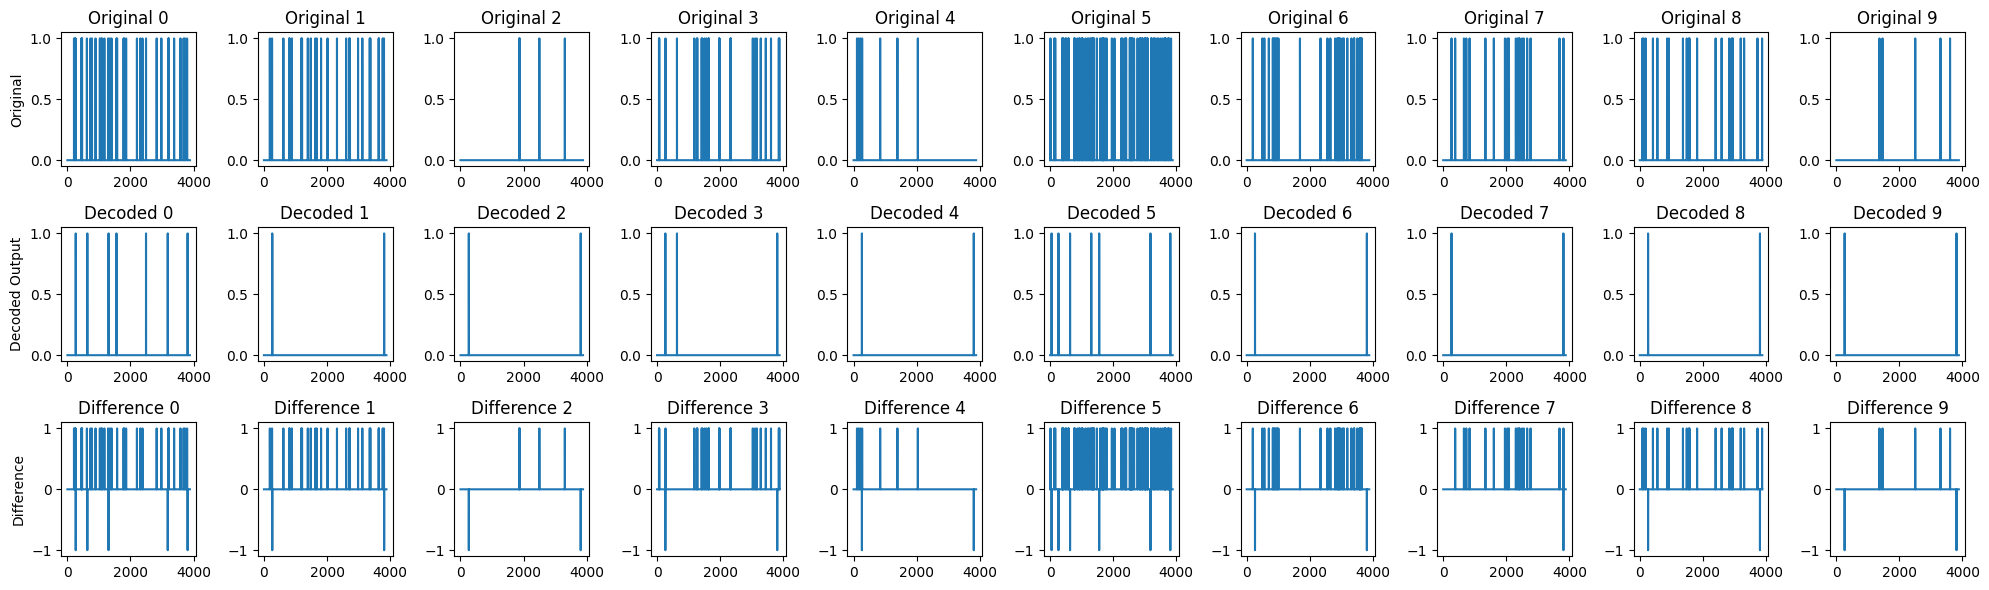

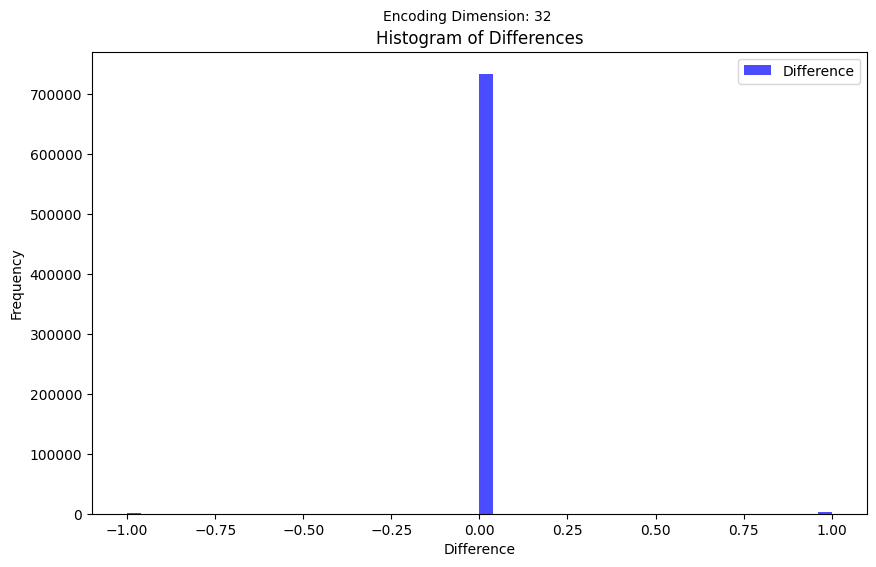

In [43]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming `data_input` is the original dataset and `decoded_data_np` is the decoded dataset

# Compute the difference
# difference = X_scaled - decoded_data
difference = X_bi - outputs_np
# Function to visualize the original vs decoded data and the difference
# def visualize_data(original, decoded, difference, encoded, num_samples=10):
#     fig, axes = plt.subplots(nrows=4, ncols=num_samples, figsize=(20, 6))
    
#     for i in range(num_samples):
#         # Original data
#         axes[0, i].plot(original[i])
#         axes[0, i].set_title(f'Original {i}')
        
#         # Decoded data
#         axes[1, i].plot(decoded[i])
#         axes[1, i].set_title(f'Decoded {i}')
        
#         # Difference
#         axes[2, i].plot(difference[i])
#         axes[2, i].set_title(f'Difference {i}')

#         # Encoded data
#         axes[3, i].plot(encoded[i])
#         axes[3, i].set_title(f'Encoded {i}')
    
#     axes[0, 0].set_ylabel('Original')
#     axes[1, 0].set_ylabel('Decoded')
#     axes[2, 0].set_ylabel('Difference')
#     axes[3, 0].set_ylabel('Encoded')
#     plt.tight_layout()
#     plt.savefig('Comparison_OriDeDifEncoded.png')
#     plt.show()

def visualize_data(original, output, difference, num_samples=10):
    fig, axes = plt.subplots(nrows=3, ncols=num_samples, figsize=(20, 6))
    
    for i in range(num_samples):
        # Original data
        axes[0, i].plot(original[i])
        axes[0, i].set_title(f'Original {i}')
        
        # Decoded data
        axes[1, i].plot(output[i])
        axes[1, i].set_title(f'Decoded {i}')
        
        # Difference
        axes[2, i].plot(difference[i])
        axes[2, i].set_title(f'Difference {i}')
    
    axes[0, 0].set_ylabel('Original')
    axes[1, 0].set_ylabel('Decoded Output')
    axes[2, 0].set_ylabel('Difference')
    plt.tight_layout()
    plt.savefig('Comparison_OriDeDifEncoded.png')
    plt.show()
    
# Visualize
visualize_data(X_bi, outputs_np, difference)

# Error histogram
plt.figure(figsize=(10, 6))
plt.hist(difference.flatten(), bins=50, color='blue', alpha=0.7, label='Difference')
plt.xlabel('Difference')
plt.ylabel('Frequency')
plt.title('Histogram of Differences')
plt.suptitle(f'Encoding Dimension: {encoding_dim}', fontsize=10, y=0.95)
plt.legend()
plt.savefig('Error_Histogram')
plt.show()


In [37]:
# np.max(X_scaled)
# 13.74772708486753
# np.min(X_scaled)
# -1.22930590661059
print(np.max(difference))
print(difference.shape)

13.78260966014104
(190, 6306)


In [40]:
array = difference
flattened_array = array.flatten()

# Method 1: Using np.sort and slicing
top_500_elements = np.sort(flattened_array)[-500:][::-1]
print("Top 500 elements using np.sort:", top_500_elements)

# Method 2: Using np.argsort to get indices of the top 5 elements
top_500_indices = np.argsort(flattened_array)[-500:]
top_500_elements = flattened_array[top_5_indices][::-1]
print("Top 500 elements using np.argsort:", top_500_elements)

Top 500 elements using np.sort: [13.78260966 13.77616717 13.76150803 13.75979538 13.75499665 13.7430942
 13.73453175 13.72883107 13.72594137 13.71170981 13.70926191 13.70858112
 13.70735153 13.69932681 13.69780429 13.69713534 13.68996989 13.68528848
 13.68434583 13.67985255 13.67905872 13.67487677 13.67454931 13.67278061
 13.67199279 13.67115168 13.67108145 13.67008437 13.6693135  13.66623318
 13.66404377 13.66370999 13.65898204 13.65833657 13.65653839 13.65442245
 13.65367533 13.65287319 13.65238414 13.65068364 13.64960122 13.64904444
 13.64484531 13.64416415 13.64313558 13.63938831 13.63707767 13.63699045
 13.63638275 13.6351896  13.63297746 13.62980299 13.62375573 13.62159665
 13.62146767 13.61767939 13.61645821 13.61128204 13.6046408  13.60122401
 13.59722624 13.5969917  13.59100808 13.57745813 13.57702214 13.57621281
 13.5696387  13.56689377 13.56628274 13.55698251 13.55522536 13.54897093
 13.54605406 13.54094566 13.53978935 13.53944089 13.53937258 13.53725692
 13.53463382 13.5318

In [51]:
total = 1198140
gt_ten = 0
for el in flattened_array:
    if el >= 10:
        gt_ten += 10

print("Total: ", total)
print("Number of difference greater than 10: ", gt_ten)
per = gt_ten/total
print("Percentage: ", per)

Total:  1198140
Number of difference greater than 10:  11590
Percentage:  0.009673326990168095


In [94]:
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(pd.__version__)
print(sklearn.__version__)


True
NVIDIA A100-SXM4-80GB
2.2.2
1.3.2


In [ ]:
input_dim=X_train.shape[1]

scaler.fit(X_train)
X_train=scaler.transform(X_train)
X_test=scaler.transform(X_test)

model=MLP_model(input_dim,2) 


optimizer = torch.optim.Adam(model.parameters(),lr=0.01,weight_decay=0.01)
criterion = nn.CrossEntropyLoss()

model = model.to(device)
criterion = criterion.to(device)

# training_data=train_dataset(encoded_train,y_train)
# testing_data=train_dataset(encoded_test,y_test)
training_data=train_dataset(X_train,y_train)
testing_data=train_dataset(X_test,y_test)



training_dataloader=DataLoader(training_data,batch_size=32,shuffle=True)
testing_dataloader=DataLoader(testing_data,batch_size=32,shuffle=True)
EPOCHS=200

for epoch in range(EPOCHS):


    train_loss,train_acc=model_train(model,training_dataloader,optimizer,criterion,device)

    test_loss,test_acc=model_evaluate(model,testing_dataloader,criterion,device)
    print(f'\t E {epoch} Train Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t E {epoch} Test. Loss: {test_loss:.3f} |  Test. Acc: {test_acc*100:.2f}%')



In [ ]:
# from xgboost import XGBClassifier
# # precision_score, f1_score, 
# xgb = XGBClassifier()
# xgb.fit(X_train, y_train)
# y_pred = xgb.predict(X_test)
# print(f"Acc ori: {accuracy_score(y_test, y_pred)}")

In [ ]:
# NLP on encoded data: Acc 49~79